## IMPORTS

In [1]:
import tensorflow as tf
import os
from glob import glob
!pip install -q tensorflow-io
import tensorflow_io as tfio


from matplotlib import pyplot as plt

from IPython import display
import imageio

import numpy as np
import math
import tensorflow.keras.preprocessing.image as prep


from copy import copy
import matplotlib.colors as colors

## HYPERPARAMETERS

## Read dataset from train and validation tfrecords 

In [2]:
# # paths for the tfrecords
# # # # # for train
train_positive =  "E:\\dataset\\Leisang\\myTry\\BleedingDataDCM/train_positive_samples_win.tfrecords"
train_negative =  'E:\\dataset\\Leisang\\myTry\\BleedingDataDCM/train_negative_samples_win.tfrecords'

# for val
val_positive =  "E:\\dataset\\Leisang\\myTry\\BleedingDataDCM/val_positive_samples_win.tfrecords"
val_negative =  'E:\\dataset\\Leisang\\myTry\\BleedingDataDCM/val_negative_samples_win.tfrecords'

# # for ubuntu

# # for train
# train_positive =  "/media/ytx/Japan_Deep_Data/dataset/LeiSang/myTry/BleedingDataDCM/train_positive_samples_unbuntu.tfrecords"
# train_negative =  '/media/ytx/Japan_Deep_Data/dataset/LeiSang/myTry/BleedingDataDCM/train_negative_samples_unbuntu.tfrecords'

# # for val
# val_positive =  "/media/ytx/Japan_Deep_Data/dataset/LeiSang/myTry/BleedingDataDCM/val_positive_samples_unbuntu.tfrecords"
# val_negative =  '/media/ytx/Japan_Deep_Data/dataset/LeiSang/myTry/BleedingDataDCM/val_negative_samples_unbuntu.tfrecords'

train_positive_dataset = tf.data.TFRecordDataset(train_positive)
train_negative_dataset = tf.data.TFRecordDataset(train_negative)

val_positive_dataset = tf.data.TFRecordDataset(val_positive)
val_negative_dataset = tf.data.TFRecordDataset(val_negative)


# fashion_mnist = tf.keras.datasets.fashion_mnist

# (train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()




In [3]:
# print(train_images.shape)
# print(test_images.shape)

# print("initial range:[{},{}]".format(train_images.min(), train_images.max()))
# # directly normalize
# train_images = train_images/255.0
# print("normalized range:[{},{}]".format(train_images.min(), train_images.max()))
# test_images = test_images/255.0


# print("range of targest[{}, {}]".format(train_labels.min(), train_labels.max()))

In [4]:
# train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
# test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

# for tx_input, tx_target in train_dataset.take(1):
#     print("range:[{},{}]".format(tx_input.numpy().min(), tx_input.numpy().max()))
#     print(tx_input.shape)
#     plt.figure()
#     plt.imshow(tx_input)
#     plt.colorbar()
#     plt.grid(False)
#     plt.title(str(tx_target.numpy()))
#     plt.show()
    
# for tx_input, tx_target in test_dataset.take(1):
#     print("range:[{},{}]".format(tx_input.numpy().min(), tx_input.numpy().max()))
#     print(tx_input.shape)
#     plt.figure()
#     plt.imshow(tx_input)
#     plt.colorbar()
#     plt.grid(False)
#     plt.title(str(tx_target.numpy()))
#     plt.show()

## PREPROCESSING

In [5]:
BUFFER_SIZE = 2048
BATCH_SIZE = 2
IMG_WIDTH = 256
IMG_HEIGHT = 256
# IMG_WIDTH = 28
# IMG_HEIGHT = 28
# project_name
project_name = "200Cls256_DropDisplayConfuRandFlipScrachStructuredBleedClassifierRunALLNoResampleWithBatchLossRec/"

# class names for the classification
# Class_names= ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
#                'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
Class_names = ["No bleed", "bleed"]

if not os.path.exists(project_name):
    os.makedirs(project_name)
# tb_log_name 
log_dir=project_name + "AE_logs/"

# image_save name
train_save_figure_path = project_name + "AE_saves/train"
test_save_figure_path = project_name + "AE_saves/test"

# training_checkpoint name
checkpoint_dir = project_name + "training_checkpoints"

# model architecture name
encoder_path = project_name + "Encoder.png"
decoder_path = project_name +"Decoder.png"
autoencoder_path = project_name + "Autoencoder.png"
new_model_path = project_name + "new_model.png"
base_model_path = project_name + "base_model.png"
classifier_path = project_name + "classifier.png"
# gif save name
anim_file = project_name + 'AE_saves.gif'

# # dicom root 
# dicom_root = 'E:/dataset/Leisang/myTry/BleedingDataDCM'

In [6]:
import math as m
# import tensorflow_addons as tfa

def resize(input, target):
    print(input.shape)
    print(target.shape)
    resized_input = tf.image.resize(input, [IMG_HEIGHT, IMG_WIDTH],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    resized_target = tf.image.resize(target, [IMG_HEIGHT, IMG_WIDTH],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    resized_input =  tf.reshape(resized_input, [IMG_HEIGHT, IMG_WIDTH, 1])
    resized_target =  tf.reshape(resized_target, [IMG_HEIGHT, IMG_WIDTH, 1])
    return  resized_input, resized_target

# @tf.function()
def truncate(x, min, max):
#     print(x.shape)
    cliped =  tf.clip_by_value(x, min, max)
    return cliped
 
def norm(x, min, max):
    # normalize_value = (value − min_value) / (max_value − min_value)
    tensor = tf.math.divide(tf.subtract(x, min),
                    tf.subtract(max, min))
    return tensor

def linear_normalization(input, min=30720.0, max=34816.0):
    truncated_input = truncate(input, min, max)
    norm_input = norm(truncated_input, min, max )
    return  norm_input


def random_crop(input_image, real_image):
    stacked_image = tf.stack([input_image, real_image], axis=0)
    cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 1])  # crop to 256x256

    return cropped_image[0], cropped_image[1]

@tf.function()
def random_jitter(input_image, real_image):
    # randomly cropping to 256 x 256 x 3
#     input_image, real_image = random_crop(input_image, real_image)

    if tf.random.uniform(()) > 0.5:
        # random mirroring
        input_image = tf.image.flip_left_right(input_image)
        real_image = tf.image.flip_left_right(real_image)

    return input_image, real_image



In [7]:
# parser the dataset to decode the features
# Create a dictionary describing the features.
image_feature_description = {
        'dicom_path': tf.io.FixedLenFeature([], tf.string),
        'seg_label': tf.io.FixedLenFeature([], tf.string), 
        'cls_label': tf.io.FixedLenFeature([], tf.int64),
}

@tf.function()
def train__parse_image_function(example_proto):
    # extract features # Parse the input tf.Example proto using the dictionary above.
    parsed_features = tf.io.parse_single_example(example_proto, image_feature_description)
       
    # decode dicom
    dicom_path = parsed_features["dicom_path"]
    image_bytes = tf.io.read_file(dicom_path)
    input_image = tf.cast(tfio.image.decode_dicom_image(image_bytes, dtype=tf.uint16), tf.float32)
    # decode mask
    seg_label = tf.cast(tf.io.decode_raw(parsed_features['seg_label'], tf.uint8), tf.float32)
    # reshape
    seg_label = tf.reshape(seg_label, [-1, 512,512,1])
    
    
    # preprocessing--->
    # 1st resize
    input_image, seg_label = resize(input_image, seg_label)
    print(input_image.shape)
    print(seg_label.shape)
    
    # 2nd random flip
    input_image, seg_label = random_jitter(input_image, seg_label)
    print(input_image.shape)
    print(seg_label.shape)
    
    # Last normalize
    input_image2 = linear_normalization(input_image) 
    seg_label =  seg_label/255.0
    
#     # 3nd random rotate
#     rinput_imag2 = Random_RotateInRnage(input_image2)
#     seg_label = Random_RotateInRnage(seg_label)
    
    #lei -window
    input_w_image = linear_normalization(input_image,min=32788.0, max=33148.0)
  
    
#     print("range of cliped_input: [{}, {}]".format(np.min(input_image), np.max(input_image)))
#     print("range of cliped_target: [{}, {}]".format(np.min(seg_label), np.max(seg_label)))
    
    
    return dicom_path, input_w_image ,input_image2, seg_label,  parsed_features["cls_label"]

@tf.function()
def test__parse_image_function(example_proto):
    # extract features # Parse the input tf.Example proto using the dictionary above.
    parsed_features = tf.io.parse_single_example(example_proto, image_feature_description)
       
    # decode dicom
    dicom_path = parsed_features["dicom_path"]
    image_bytes = tf.io.read_file(dicom_path)
    input_image = tf.cast(tfio.image.decode_dicom_image(image_bytes, dtype=tf.uint16), tf.float32)
    # decode mask
    seg_label = tf.cast(tf.io.decode_raw(parsed_features['seg_label'], tf.uint8), tf.float32)
    # reshape
    seg_label = tf.reshape(seg_label, [-1, 512,512,1])
    
    
    # preprocessing--->
    # 1st resize
    input_image, seg_label = resize(input_image, seg_label)
    print(input_image.shape)
    print(seg_label.shape)
    
#     # 2nd random flip
#     input_image, seg_label = random_jitter(input_image, seg_label)
#     print(input_image.shape)
#     print(seg_label.shape)
    
    # Last normalize
    input_image2 = linear_normalization(input_image) 
    seg_label =  seg_label/255.0
    
#     # 3nd random rotate
#     rinput_imag2 = Random_RotateInRnage(input_image2)
#     seg_label = Random_RotateInRnage(seg_label)
    
    #lei -window
    input_w_image = linear_normalization(input_image,min=32788.0, max=33148.0)
  
    
#     print("range of cliped_input: [{}, {}]".format(np.min(input_image), np.max(input_image)))
#     print("range of cliped_target: [{}, {}]".format(np.min(seg_label), np.max(seg_label)))
    
    
    return dicom_path, input_w_image ,input_image2, seg_label,  parsed_features["cls_label"]


# train: positive
train_nb_pos = 3035
train_nb_neg = 33588
parsed_train_positive_dataset = train_positive_dataset.map(train__parse_image_function)
parsed_train_negative_dataset = train_negative_dataset.map(train__parse_image_function)

val_nb_pos = 238
val_nb_neg = 4420
parsed_val_positive_dataset = val_positive_dataset.map(test__parse_image_function)
parsed_val_negative_dataset = val_negative_dataset.map(test__parse_image_function)

(None, None, None, None)
(None, 512, 512, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(None, None, None, None)
(None, 512, 512, 1)
(256, 256, 1)
(256, 256, 1)


dicom_path: tf.Tensor(b'E:\\dataset\\Leisang\\myTry\\BleedingDataDCM\\train/ZA-006_000/00001164.DCM', shape=(), dtype=string)
input_image.shape (256, 256, 1)
seg_label (256, 256, 1)
cls_label tf.Tensor(1, shape=(), dtype=int64)
masked_in range:[0.0, 1.532958984375]
masked range:[1.5166015625, 1.532958984375]
tf.Tensor(b'E:\\dataset\\Leisang\\myTry\\BleedingDataDCM\\train/ZA-006_000/00001164.DCM', shape=(), dtype=string)

E:\Projects\Intepreters\Anaconda\envs\TF21\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 65306 missing from current font.
  font.set_text(s, 0.0, flags=flags)



dicom_path: tf.Tensor(b'E:\\dataset\\Leisang\\myTry\\BleedingDataDCM\\train/ZA-006_000/00001165.DCM', shape=(), dtype=string)
input_image.shape (256, 256, 1)
seg_label (256, 256, 1)
cls_label tf.Tensor(1, shape=(), dtype=int64)
masked_in range:[0.0, 1.5380859375]
masked range:[1.5068359375, 1.5380859375]
tf.Tensor(b'E:\\dataset\\Leisang\\myTry\\BleedingDataDCM\\train/ZA-006_000/00001165.DCM', shape=(), dtype=string)


E:\Projects\Intepreters\Anaconda\envs\TF21\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 65306 missing from current font.
  font.set_text(s, 0, flags=flags)


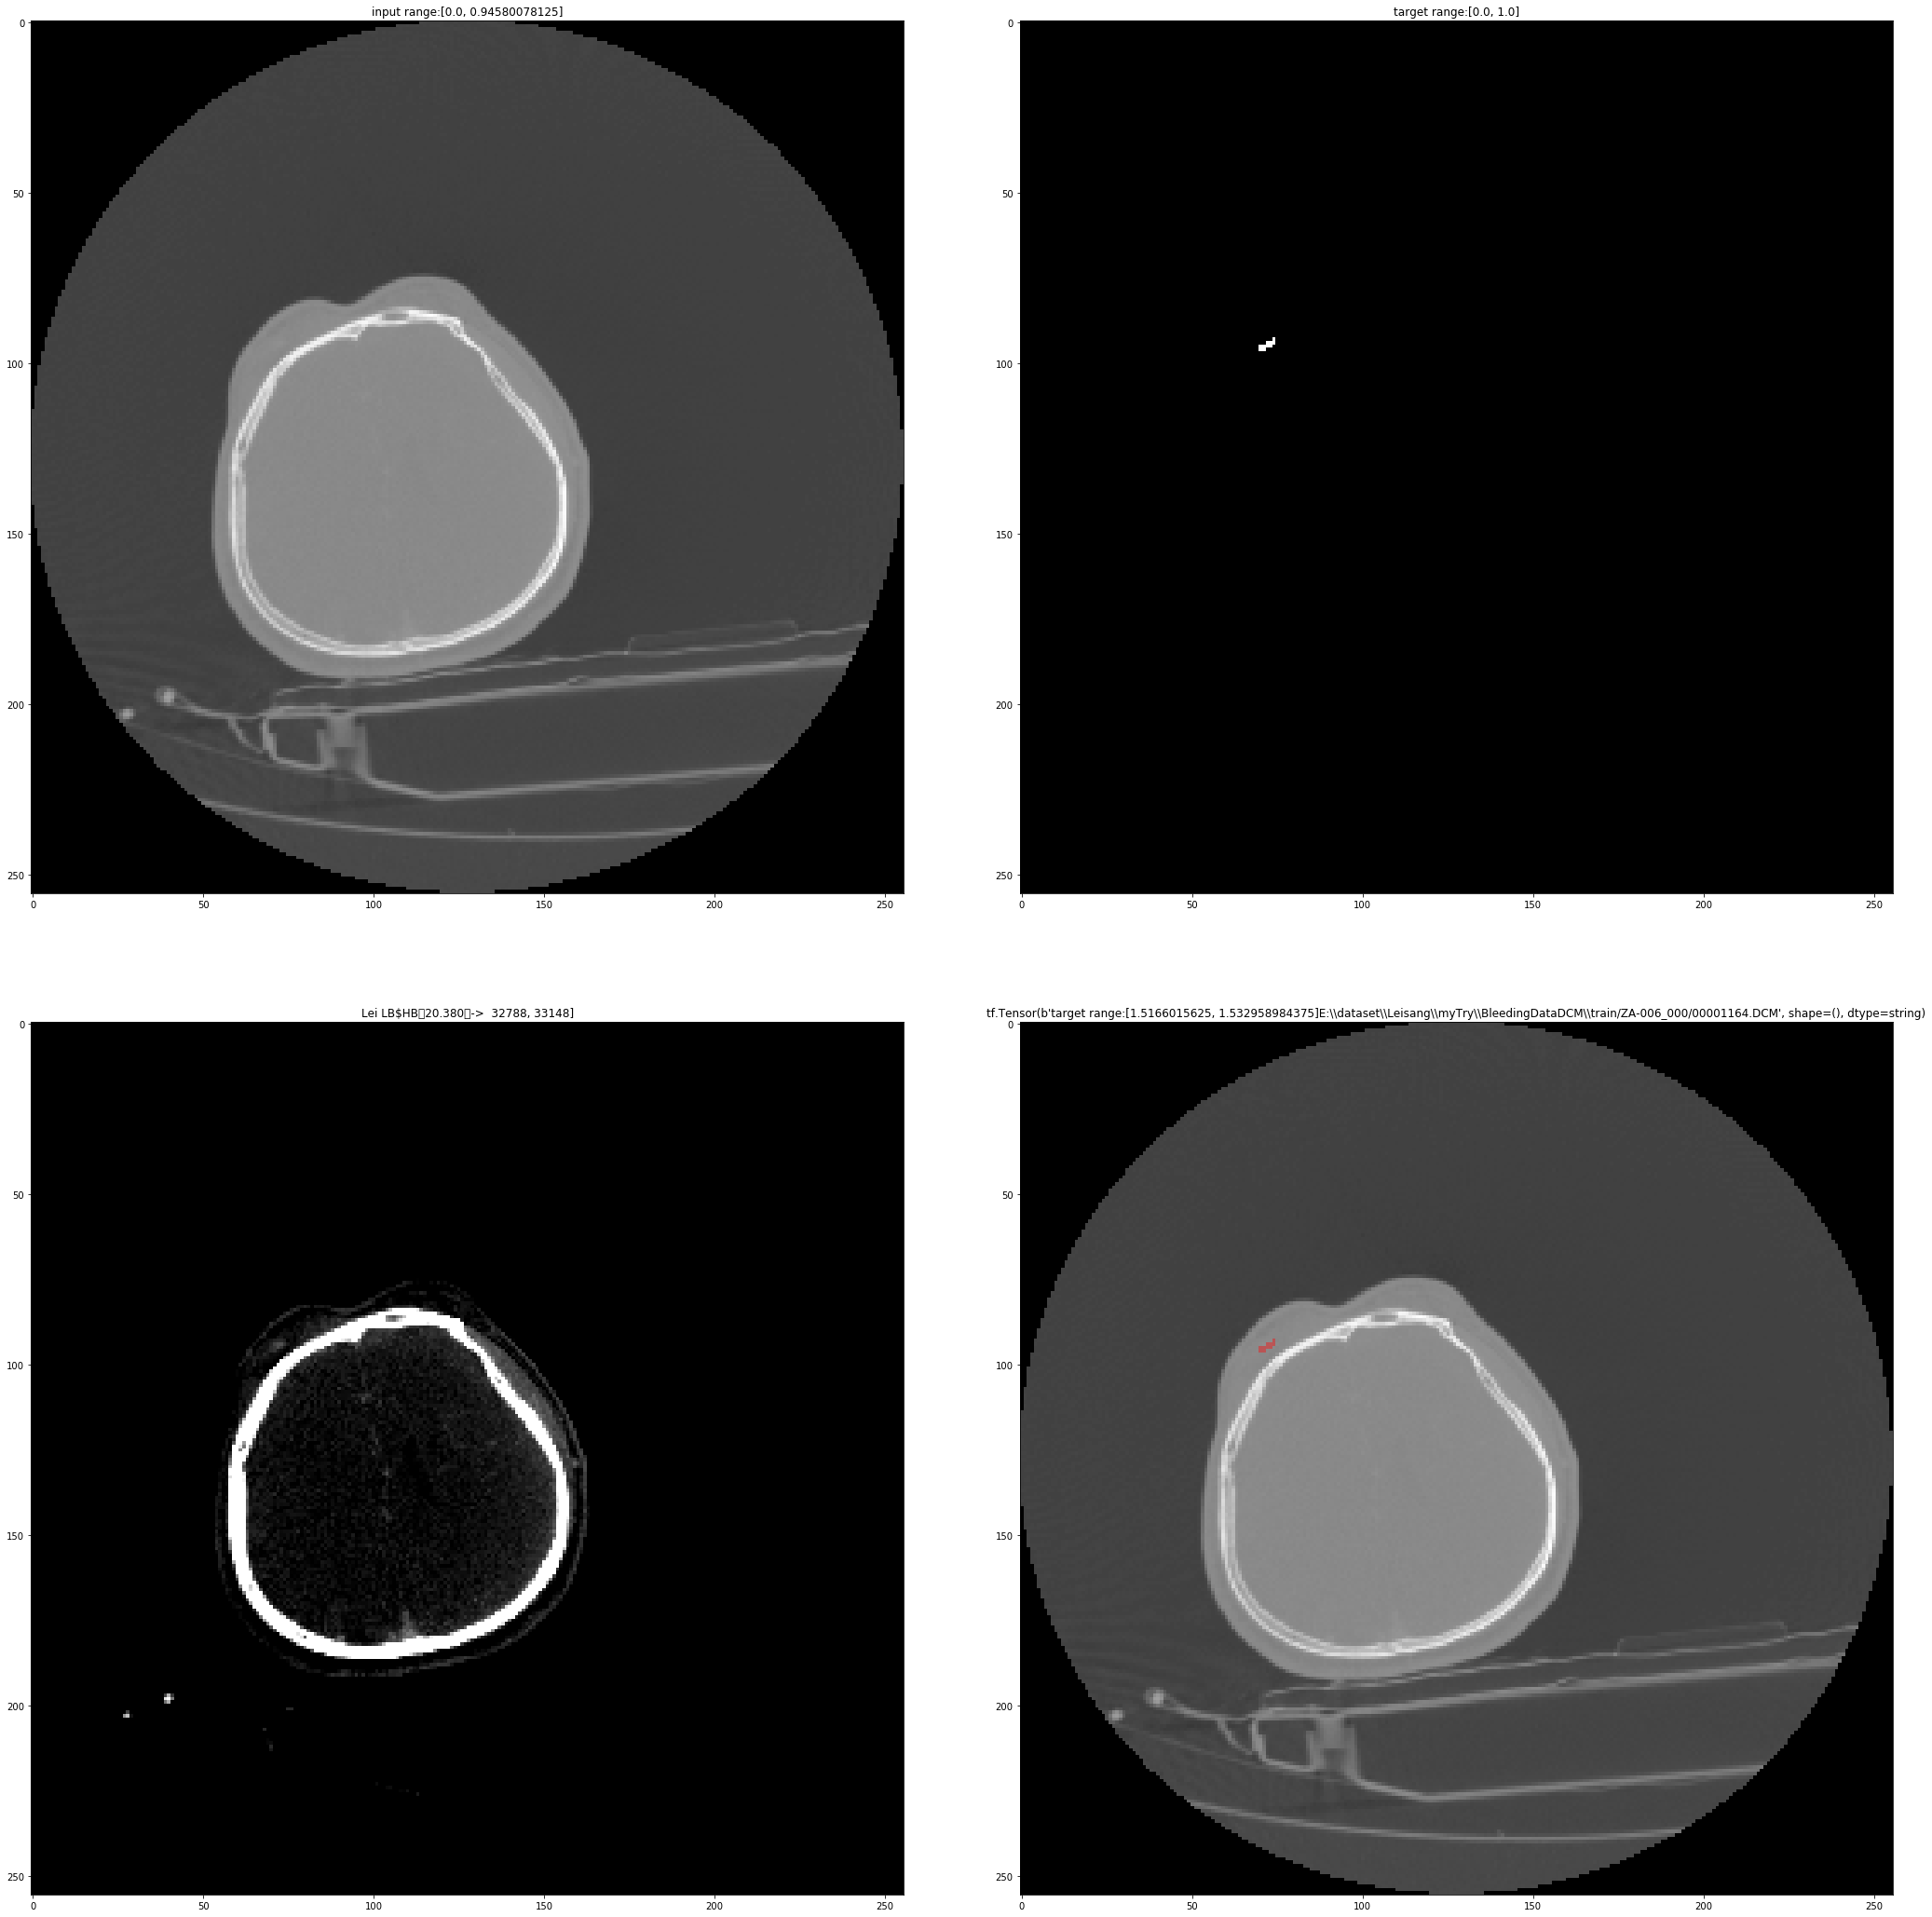

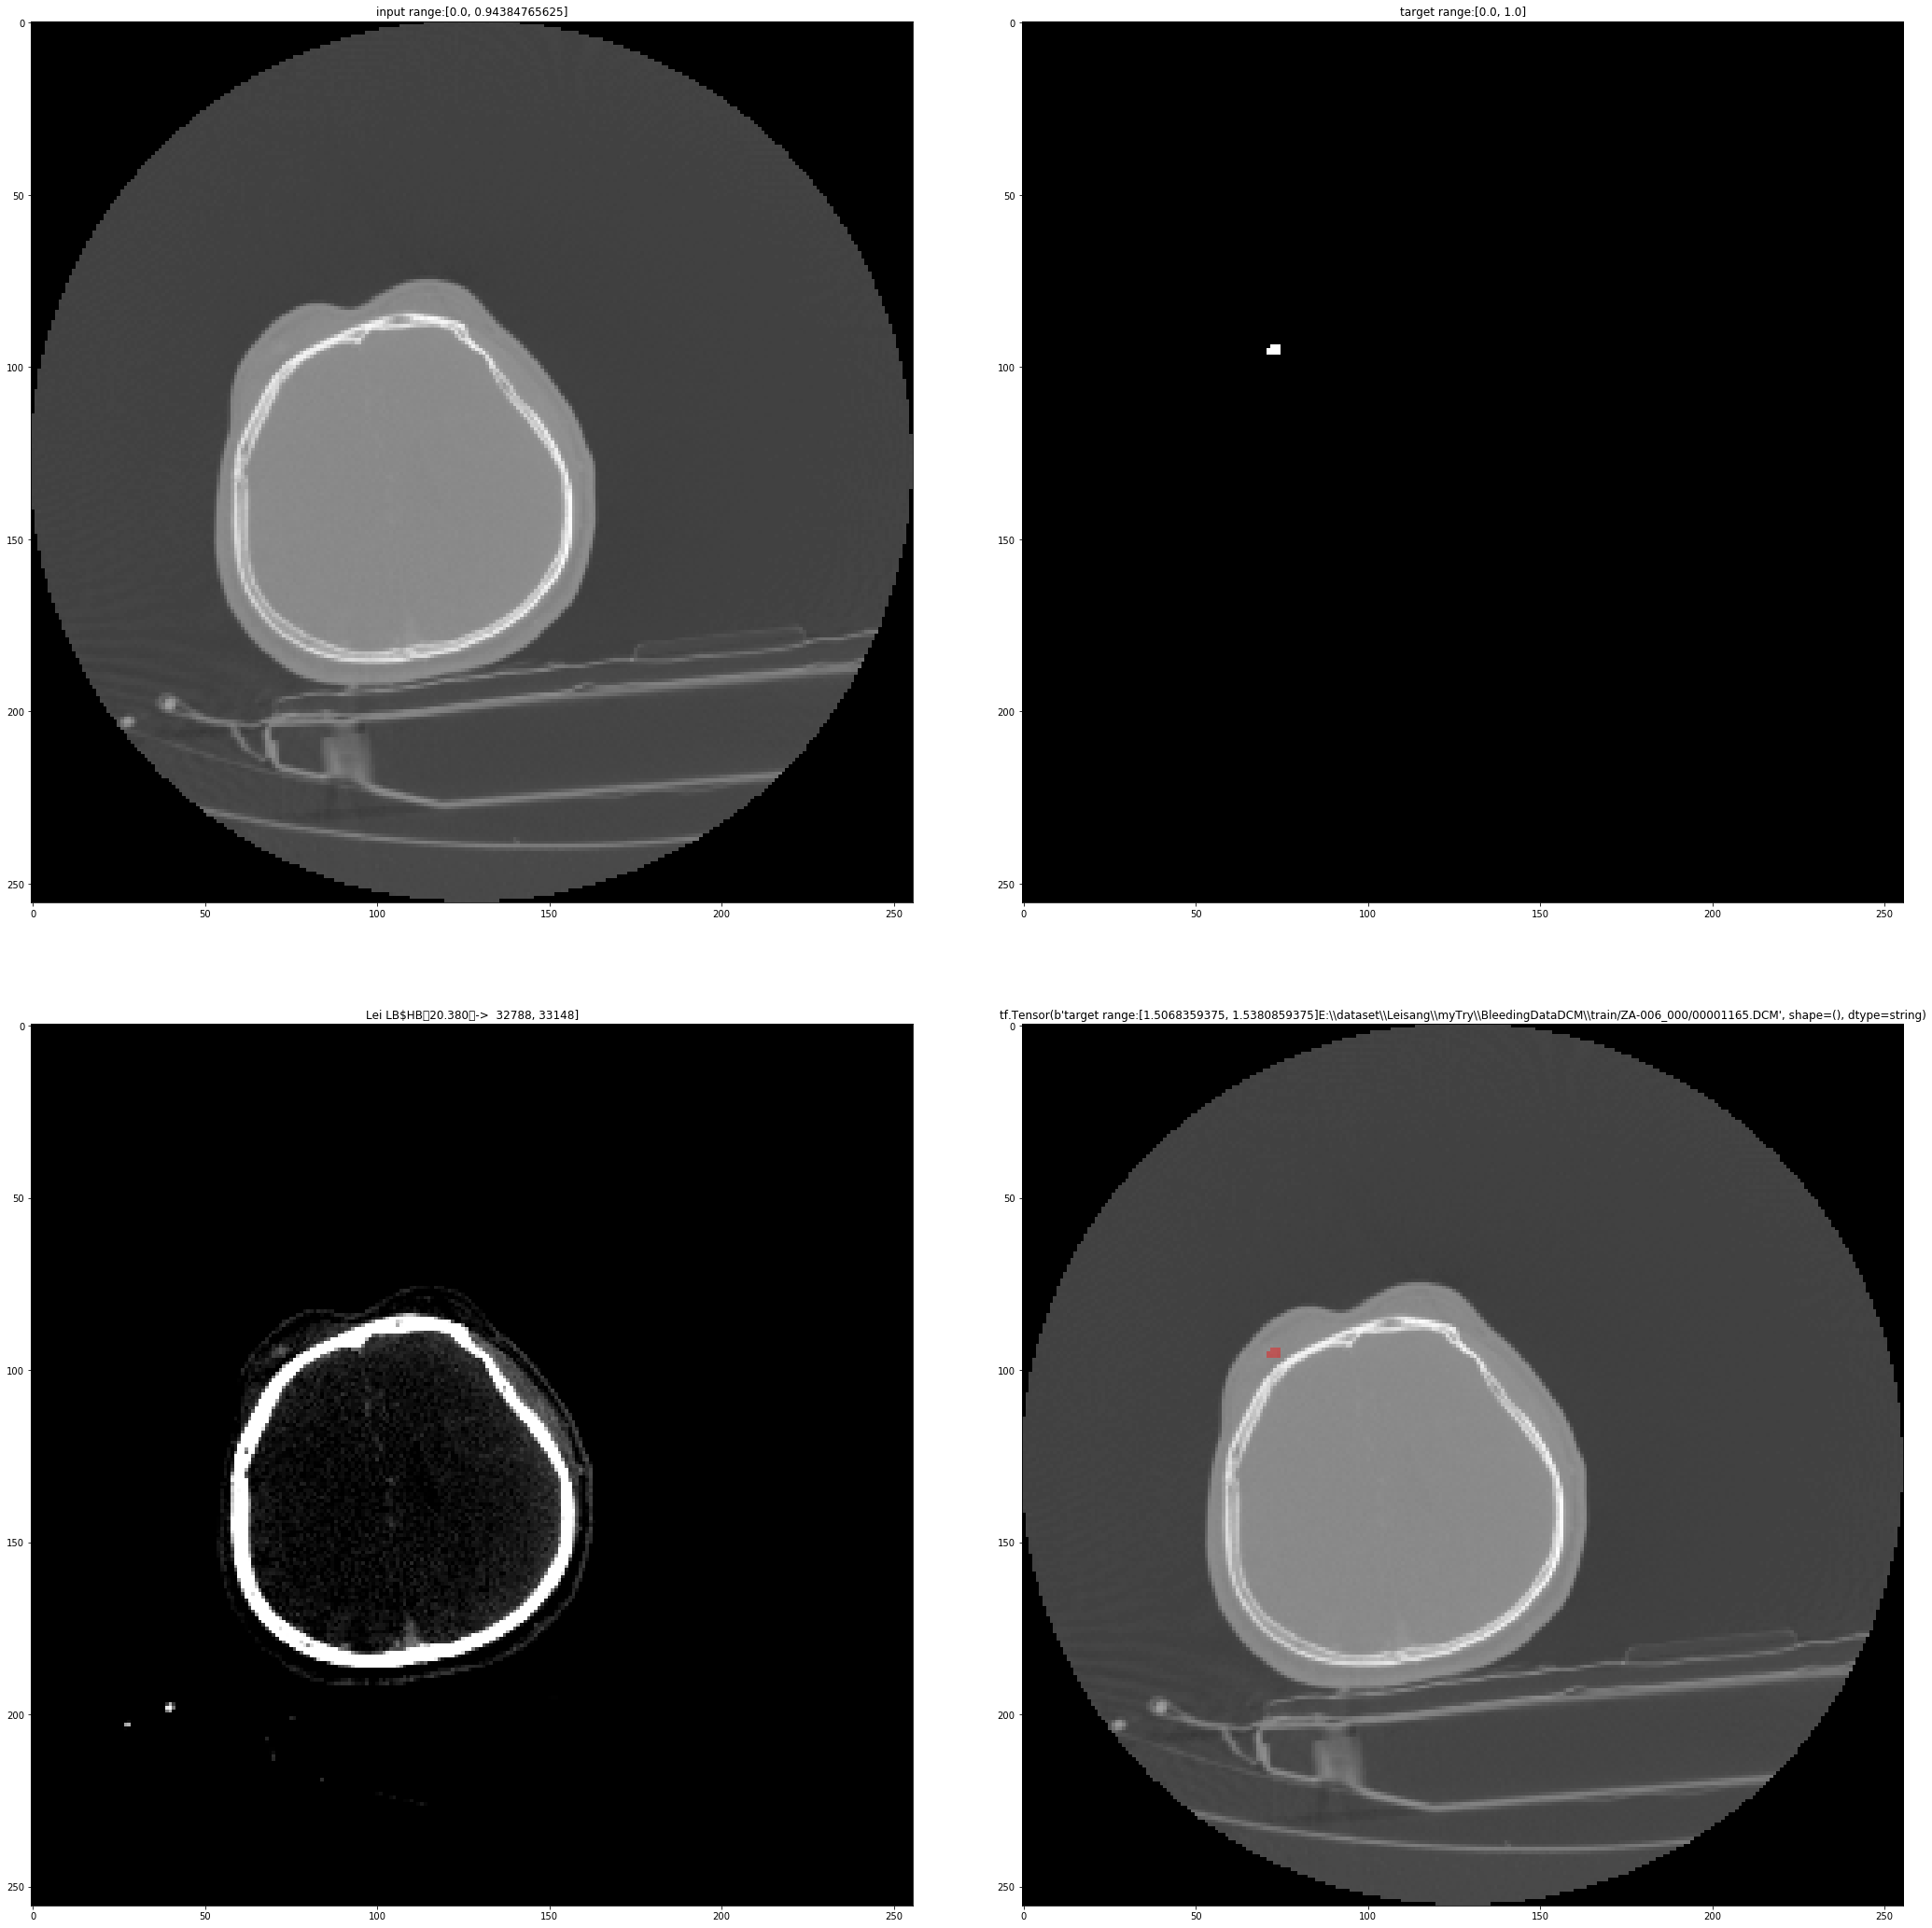

In [8]:
# # check the dataset
# def winwise(input,LB,HB):
#         # 20 ,380 for range (-32768, 32767)
#         # for tf input , (0, 65535)-? LB =  32788, 33148
#         input[input<LB] = LB # low boundary , if < LW , set to LW
#         input[input>HB] = HB # high boundary, if > Hw, Set to 255
#         return input


palette = copy(plt.cm.gray)
palette.set_over('r', 1.0)
for image_features in parsed_train_positive_dataset.take(2):
    dicom_path =  image_features[0]
    norm_input_w_image =  image_features[1]
    norm_input =  image_features[2]
    #     dicom_path = image_features[0].numpy()
    norm_target = image_features[3]
    cls_label = image_features[4]
    print("dicom_path:", dicom_path)
    print("input_image.shape", norm_input.shape)
    print("seg_label", norm_target.shape)
    print("cls_label", cls_label)
    # reshape label 
#     norm_target =  tf.reshape(norm_target, norm_input.shape)
    # # for lab ubuntu system
    # input, target, image_path= load('/media/ytx/Japan_Deep_Data/dataset/LeiSang/myTry/BleedingDataDCM/train/ZA-006_000/00000001.DCM')
    fig, axes = plt.subplots(2,2, figsize=(30,30))

    axes[0, 0].imshow(np.squeeze(norm_input.numpy()), cmap='gray')
    axes[0, 0].set_title('input range:[{}, {}]'.format((norm_input.numpy().min()), np.max(norm_input.numpy())))
    axes[0, 1].imshow(np.squeeze(norm_target.numpy()), cmap='gray')
    axes[0, 1].set_title('target range:[{}, {}]'.format(np.min(norm_target), np.max(norm_target)))
    
    axes[1, 0].imshow(np.squeeze(norm_input_w_image), cmap='gray')
    axes[1, 0].set_title('Lei LB$HB：20.380：->  32788, 33148]')
    
    mask =  np.squeeze(norm_target.numpy())
    masked_in = norm_target + norm_input
    print('masked_in range:[{}, {}]'.format((masked_in.numpy().min()), masked_in.numpy().max()))

    masked = np.ma.masked_where(norm_target==0, masked_in)  # this is only generated mask
    print('masked range:[{}, {}]'.format(masked.min(), masked.max())) 
    axes[1, 1].imshow(np.squeeze(norm_input), cmap='gray')
    axes[1, 1].imshow(np.squeeze(masked), palette, colors.Normalize(vmin=0, vmax=1), interpolation='none', alpha=0.4)
    axes[1, 1].set_title('target range:[{}, {}]'.format(np.min(masked), np.max(masked)) + dicom_path)
    fig.tight_layout()
    
    print(dicom_path)

## DEFINE LOAD FUNCTION IN INPUT PIPELINE

## INPUT PIPELINE

In [9]:
# balance the dataset

# 
# train_dataset = tf.data.experimental.sample_from_datasets([parsed_train_positive_dataset, parsed_train_negative_dataset], weights=[0.5, 0.5])
train_dataset =  parsed_train_positive_dataset.concatenate(parsed_train_negative_dataset)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(2)

test_dataset = parsed_val_positive_dataset.concatenate(parsed_val_negative_dataset)
# test_dataset = test_dataset.shuffle(BUFFER_SIZE)  # for the random check if not comment it
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(2)


# # test positive dataset
# test_positive_dataset =  parsed_val_positive_dataset
# test_positive_dataset = test_positive_dataset.batch(BATCH_SIZE).prefetch(2)
# # test negative dataset
# test_negative_dataset =  parsed_val_negative_dataset
# test_negative_dataset = test_negative_dataset.batch(BATCH_SIZE).prefetch(2)

# To use this dataset, you'll need the number of steps per epoch.

The definition of "epoch" in this case is less clear. Say it's the number of batches required to see each positive example once:

In [10]:
resampled_steps_per_epoch = np.ceil(2.0*train_nb_pos/BATCH_SIZE)

n_positive_test_batches = np.ceil(val_nb_pos/BATCH_SIZE)

print("resampled_steps_per_epoch:", resampled_steps_per_epoch)
print("n_positive_test_batches:", n_positive_test_batches)

resampled_steps_per_epoch: 3035.0
n_positive_test_batches: 119.0


dicom_path: tf.Tensor(b'E:\\dataset\\Leisang\\myTry\\BleedingDataDCM\\val/ZA-049_001/00000435.DCM', shape=(), dtype=string)
input_image.shape (256, 256, 1)
seg_label (256, 256, 1)
cls_label tf.Tensor(1, shape=(), dtype=int64)
masked_in range:[0.0, 1.531982421875]
masked range:[1.51318359375, 1.531982421875]
tf.Tensor(b'E:\\dataset\\Leisang\\myTry\\BleedingDataDCM\\val/ZA-049_001/00000435.DCM', shape=(), dtype=string)


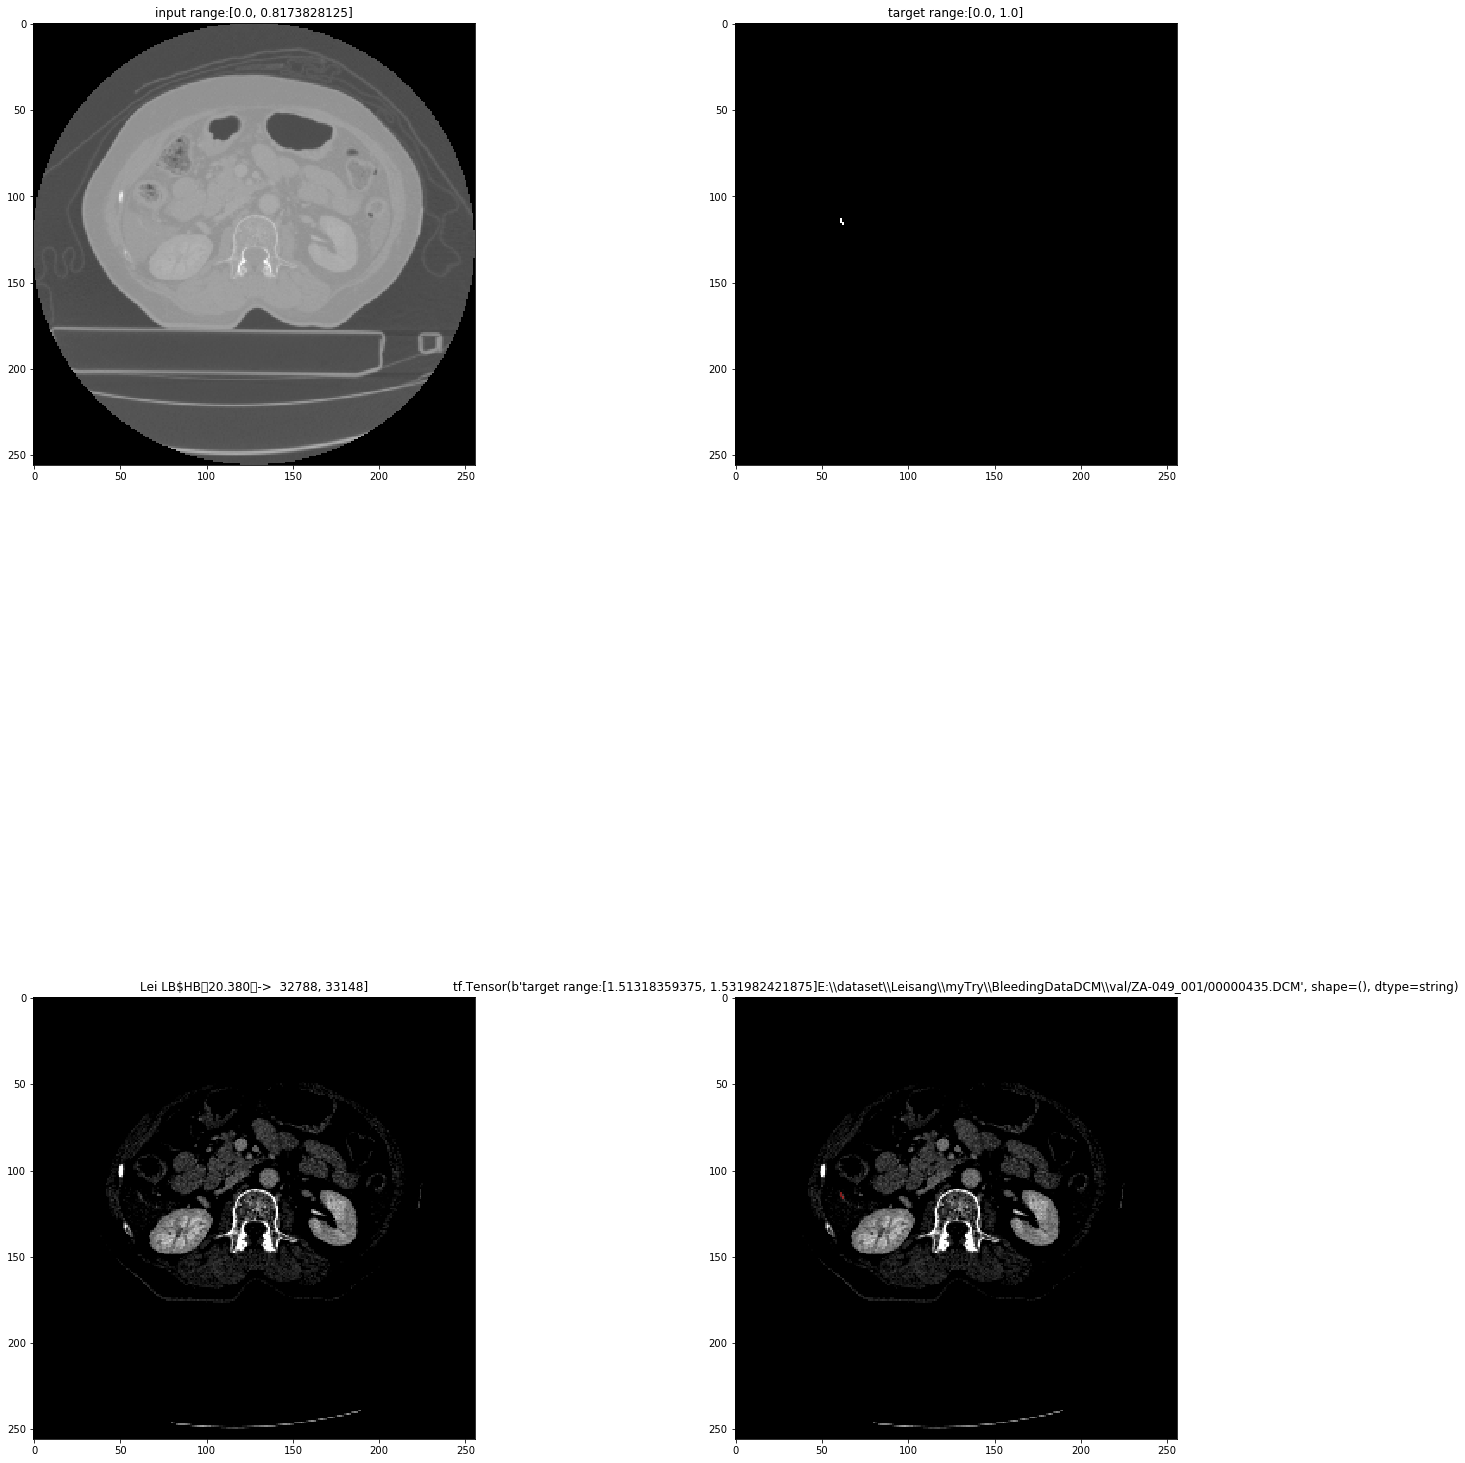

In [11]:
#  check the dataset
for image_features  in test_dataset.take(1):
    dicom_path =  image_features[0][0]
    norm_input_w_image =  image_features[1][0]
    norm_input =  image_features[2][0]
    #     dicom_path = image_features[0].numpy()
    norm_target = image_features[3][0]
    cls_label = image_features[4][0]
    print("dicom_path:", dicom_path)
    print("input_image.shape", norm_input.shape)
    print("seg_label", norm_target.shape)
    print("cls_label", cls_label)
    
    fig, axes = plt.subplots(2,2, figsize=(20,30))

    axes[0, 0].imshow(np.squeeze(norm_input.numpy()), cmap='gray')
    axes[0, 0].set_title('input range:[{}, {}]'.format((norm_input.numpy().min()), np.max(norm_input.numpy())))
    axes[0, 1].imshow(np.squeeze(norm_target.numpy()), cmap='gray')
    axes[0, 1].set_title('target range:[{}, {}]'.format(np.min(norm_target), np.max(norm_target)))
    
    axes[1, 0].imshow(np.squeeze(norm_input_w_image), cmap='gray')
    axes[1, 0].set_title('Lei LB$HB：20.380：->  32788, 33148]')
    
    mask =  np.squeeze(norm_target.numpy())
    masked_in = norm_target + norm_input
    print('masked_in range:[{}, {}]'.format((masked_in.numpy().min()), masked_in.numpy().max()))

    masked = np.ma.masked_where(norm_target==0, masked_in)  # this is only generated mask
    print('masked range:[{}, {}]'.format(masked.min(), masked.max())) 
    axes[1, 1].imshow(np.squeeze(norm_input_w_image), cmap='gray')
    axes[1, 1].imshow(np.squeeze(masked), palette, colors.Normalize(vmin=0, vmax=1), interpolation='none', alpha=0.4)
    axes[1, 1].set_title('target range:[{}, {}]'.format(np.min(masked), np.max(masked)) + dicom_path)
    fig.tight_layout()
    
    print(dicom_path)
    
    

## DESIGN MODEL

In [12]:
OUTPUT_CHANNELS = 1
latent_dim =50

In [13]:
# model input conponents
en_inputs = tf.keras.layers.Input(shape=[IMG_HEIGHT,IMG_HEIGHT,1])
de_inputs = tf.keras.layers.Input(shape=[latent_dim])
# full model design and construct encoder, decoder , AE object
# entire model

# Define encoder part ---->
x = en_inputs
x = tf.keras.layers.Conv2D(
                filters=16, kernel_size=3, strides=(1, 1), activation='relu', padding="same")(x)
x = tf.keras.layers.Conv2D(
                filters=32, kernel_size=3, strides=(2, 2), activation='relu', padding="same")(x)
x = tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation='relu', padding="SAME")(x)
x = tf.keras.layers.Conv2D(
                filters=128, kernel_size=3, strides=(2, 2), activation='relu',padding="SAME")(x)
x = tf.keras.layers.Flatten()(x)
# No activation
latent_v = tf.keras.layers.Dense(latent_dim)(x)
encoder = tf.keras.Model(inputs=en_inputs, outputs=latent_v, name='encoder')


# Define decoder part ---->
x = tf.keras.layers.Dense(units=131072, activation=tf.nn.relu)(de_inputs)
x = tf.keras.layers.Reshape(target_shape=(32, 32, 128))(x)
x = tf.keras.layers.Conv2DTranspose(
      filters=64,
      kernel_size=3,
      strides=(2, 2),
      padding="SAME",
      activation='relu')(x)
x = tf.keras.layers.Conv2DTranspose(
      filters=32,
      kernel_size=3,
      strides=(2, 2),
      padding="SAME",
      activation='relu')(x)
x = tf.keras.layers.Conv2DTranspose(
      filters=16,
      kernel_size=3,
      strides=(2, 2),
      padding="SAME",
      activation='relu')(x)

decoded = tf.keras.layers.Conv2DTranspose(
      filters=1, kernel_size=3, strides=(1, 1), padding="SAME", use_bias=True)(x)
# output with sigmoid
decoded =  tf.sigmoid(decoded)
decoder = tf.keras.Model(inputs=de_inputs, outputs=decoded, name='decoder')


# Define AE model---->
outputs = decoder(latent_v)
autoencoder =  tf.keras.Model(inputs=en_inputs, outputs=outputs, name='AE')

# a sperately decoder is struggle leave for the moment

# # # create a placeholder for an encoded (32-dimensional) input
# encoded_input = tf.keras.layers.Input(shape=(latent_dim))
# # # retrieve the last layer of the autoencoder model
# decoder_layer = autoencoder.layers[-1]
# # # create the decoder model
# decoder = tf.keras.Model(encoded_input, decoder_layer)
             

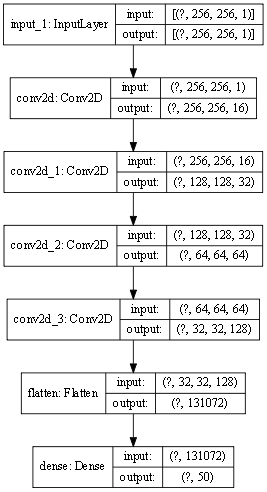

In [14]:
tf.keras.utils.plot_model(encoder, to_file=encoder_path, show_shapes=True, dpi=64)

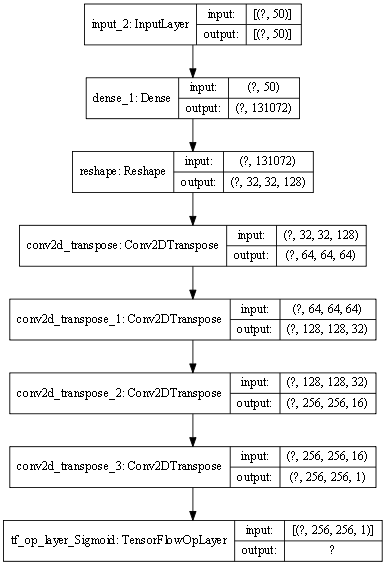

In [15]:
tf.keras.utils.plot_model(decoder, to_file=decoder_path, show_shapes=True, dpi=64)

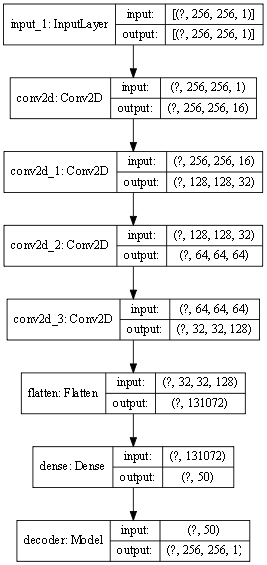

In [16]:
tf.keras.utils.plot_model(autoencoder, to_file=autoencoder_path, show_shapes=True, dpi=64)

## OPTIMIZER AND OBJECTIVE LOSSES


## Training PREPARING

In [17]:
## get current working directory
cwd = os.getcwd()
print("current working directory:", cwd)
train_full_AE_saves =  os.path.join(cwd, train_save_figure_path)
test_full_AE_saves =  os.path.join(cwd, test_save_figure_path)
print("train_full_AE_saves:", train_full_AE_saves)
print("test_full_AE_saves:", test_full_AE_saves)


if not os.path.exists(train_full_AE_saves):
    os.makedirs(train_full_AE_saves)

if not os.path.exists(test_full_AE_saves):
    os.makedirs(test_full_AE_saves)
    
    
train_predictions_save_path =os.path.join(train_full_AE_saves, "Predictions")
test_predictions_save_path =os.path.join(test_full_AE_saves, "Predictions")

test_confusion_matrix =  os.path.join(test_full_AE_saves, "Confusion_Matrix")
test_cm_diags =  os.path.join(test_full_AE_saves, "Confusion_Matrix_diagnoise_with_Epoch")

test_batch_losses =  os.path.join(test_full_AE_saves, "Test_batch_losses")

test_EpochValidation_save_path =os.path.join(test_full_AE_saves, "EpochValidation")
test_EpochValidation_save_path_pred =os.path.join(test_EpochValidation_save_path, "PredictionsOnly")
if not os.path.exists(train_predictions_save_path):
    os.makedirs(train_predictions_save_path)
if not os.path.exists(test_predictions_save_path):
    os.makedirs(test_predictions_save_path)
if not os.path.exists(test_EpochValidation_save_path):
    os.makedirs(test_EpochValidation_save_path)
if not os.path.exists(test_EpochValidation_save_path_pred):
    os.makedirs(test_EpochValidation_save_path_pred)   
if not os.path.exists(test_confusion_matrix):
    os.makedirs(test_confusion_matrix)       
if not os.path.exists(test_cm_diags):
    os.makedirs(test_cm_diags) 
if not os.path.exists(test_batch_losses):
    os.makedirs(test_batch_losses)   
    

    
    
def new_generate_images(model, norm_input, norm_input_w_image, norm_seg_target, cls_target, batch_idx, epoch, save=True, Train_or_not=True, Epoch_val =False):
#     prediction = model(test_input, training=True)
    
    class_sigmoid_output = model(norm_input, training=False)
    print("class_sigmoid_output shape:", class_sigmoid_output.shape)
    
    cls_pred =  np.argmax(class_sigmoid_output[0])
 
    
    norm_input =norm_input[0]
    norm_input_w_image =norm_input_w_image[0]
    norm_target =norm_seg_target[0]
    cls_target = cls_target[0]
#     display_list = [np.squeeze(test_input[0]), np.squeeze(tar[0]), np.squeeze(prediction[0])]
#     title = ['Input range:[{},{}]'.format(test_input[0].numpy().min(), test_input[0].numpy().max()), 
#            'GT range:[{},{}]'.format(tar[0].numpy().min(), tar[0].numpy().max()), 'en-to-de Pred. out {}'.format(prediction.shape)]
    
    fig, axes = plt.subplots(2,2, figsize =(10,10))
    axes[0, 0].imshow(np.squeeze(norm_input.numpy()), cmap='gray')
    axes[0, 0].set_title('input range:[{}, {}]'.format((norm_input.numpy().min()), np.max(norm_input.numpy())))
    axes[0, 1].imshow(np.squeeze(norm_target.numpy()), cmap='gray')
    axes[0, 1].set_title('target range:[{}, {}]'.format(np.min(norm_target), np.max(norm_target)))
    
    axes[1, 0].imshow(np.squeeze(norm_input_w_image), cmap='gray')
    axes[1, 0].set_title('Lei LB$HB 20,380->  32788, 33148]\n cls_pred:{}; cls_tar:{}'.format(cls_pred, cls_target))
    
    mask =  np.squeeze(norm_target.numpy())
    masked_in = norm_target + norm_input
    print('masked_in range:[{}, {}]'.format((masked_in.numpy().min()), masked_in.numpy().max()))

    masked = np.ma.masked_where(norm_target==0, masked_in)  # this is only generated mask
    print('masked range:[{}, {}]'.format(masked.min(), masked.max())) 
    axes[1, 1].imshow(np.squeeze(norm_input_w_image), cmap='gray')
    
    palette1 = copy(plt.cm.gray)
    palette1.set_over('r', 1.0)
    axes[1, 1].imshow(np.squeeze(masked), palette1, colors.Normalize(vmin=0, vmax=1), interpolation='none', alpha=0.4)
    axes[1, 1].set_title('target range:[{}, {}]:'.format(np.min(masked), np.max(masked)))
    
#     axes.axis('off')
    
    
    fig.tight_layout()
    
    if save==True :
        if Train_or_not:
            fig.savefig(train_save_figure_path + "/Train_image_at_epoch_{:04d}_batch_{}.png".format(epoch,batch_idx))
        else:
            if Epoch_val:
                fig.savefig(test_EpochValidation_save_path + "/Test_image_at_epoch_{:04d}_batch_{}_idx.png".format(epoch,batch_idx))
            else:
                fig.savefig(test_save_figure_path + "/Test_image_at_epoch_{:04d}_batch_{}.png".format(epoch,batch_idx))
     
    
    
    plt.show()

current working directory: E:\Projects\TF2\Dicom
train_full_AE_saves: E:\Projects\TF2\Dicom\200Cls256_DropDisplayConfuRandFlipScrachStructuredBleedClassifierRunALLNoResample/AE_saves/train
test_full_AE_saves: E:\Projects\TF2\Dicom\200Cls256_DropDisplayConfuRandFlipScrachStructuredBleedClassifierRunALLNoResample/AE_saves/test


## TRAINING

In [18]:
import datetime

epochs = 100
# define opitmizer 
optimizer =  tf.keras.optimizers.Adam(1e-4)






# define check points


# pre_saved_ckpt_path = os.path.join(checkpoint_dir, "ckpt")
# change to pre-saved model path: 
# 8 
# pre_saved_ckpt_path = "E:\\Projects\\logs\dicoms\\fixedArranged\\fixed\\8Bleed_AE_Huber_BCE_Sigmoid_NormNarrow_ShuffleTr_RandWinTrTe_SaveBest\\training_checkpoints\\ckpt"
# # for ubuntu
# pre_saved_ckpt_path = "/media/ytx/Japan_Deep_Data/DicomProject2020/logs/NewFramework/fixed/8Bleed_AE_Huber_BCE_Sigmoid_NormNarrow_ShuffleTr_RandWinTrTe_SaveBest/training_checkpoints/ckpt"
# # the path for the new training
# checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

# if not os.path.exists(pre_saved_ckpt_path):
#     print("please check the pre-trained saved model path")
# #  contents of states to be saved as attributes on the checkpoint object
# checkpoint_ob = tf.train.Checkpoint(step= tf.Variable(1),
#                                     epoch=  tf.Variable(1),
#                                     optimizer=optimizer,
#                                  encoder=encoder,
#                                  decoder =  decoder,
#                                  autoencoder = autoencoder
#                                  )
# define restore checkpoint manager
# manager =  tf.train.CheckpointManager(checkpoint_ob, pre_saved_ckpt_path, max_to_keep=1)

# # define checkpoint manager for new training
# manager =  tf.train.CheckpointManager(checkpoint_ob, checkpoint_prefix, max_to_keep=1)

datetime_rec =  datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

train_summary_writer = tf.summary.create_file_writer(
  log_dir + "train")
val_summary_writer = tf.summary.create_file_writer(
  log_dir + "val")

In [19]:
# start tensorboard
# !kill 5032
%load_ext tensorboard
%tensorboard --logdir {log_dir}

Reusing TensorBoard on port 6006 (pid 25348), started 21:01:41 ago. (Use '!kill 25348' to kill it.)

In [20]:
# # load pre-trained model
# checkpoint_ob.restore(restore_manager.latest_checkpoint)

# step =  checkpoint_ob.step
# epoch =  checkpoint_ob.epoch
# print(int(step))
# print(int(epoch))

# AE=  checkpoint_ob.autoencoder
# en = checkpoint_ob.encoder
# de =  checkpoint_ob.decoder
# print(AE)


AE=  autoencoder
en = encoder
de =  decoder

## use the pre-saved encoder as the base model and design the new model
base_model  = en
print(base_model.trainable)

dicom_path: tf.Tensor(
[b'E:\\dataset\\Leisang\\myTry\\BleedingDataDCM\\val/ZA-049_001/00000435.DCM'
 b'E:\\dataset\\Leisang\\myTry\\BleedingDataDCM\\val/ZA-049_001/00000436.DCM'], shape=(2,), dtype=string)
input_image.shape (2, 256, 256, 1)
seg_label (2, 256, 256, 1)
cls_label tf.Tensor([1 1], shape=(2,), dtype=int64)
class_sigmoid_output shape: (2, 50)
masked_in range:[0.0, 1.531982421875]
masked range:[1.51318359375, 1.531982421875]


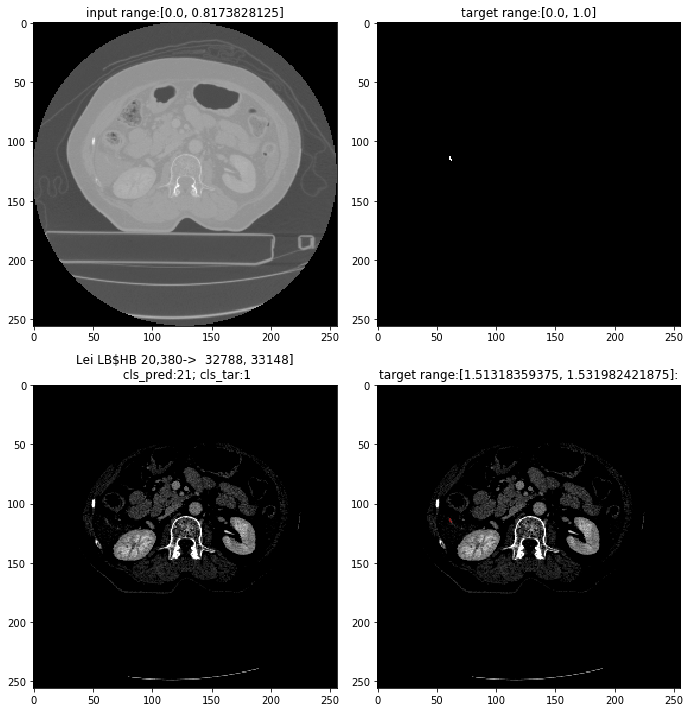

dicom_path: tf.Tensor(
[b'E:\\dataset\\Leisang\\myTry\\BleedingDataDCM\\val/ZA-049_001/00000437.DCM'
 b'E:\\dataset\\Leisang\\myTry\\BleedingDataDCM\\val/ZA-049_001/00000438.DCM'], shape=(2,), dtype=string)
input_image.shape (2, 256, 256, 1)
seg_label (2, 256, 256, 1)
cls_label tf.Tensor([1 1], shape=(2,), dtype=int64)
class_sigmoid_output shape: (2, 50)
masked_in range:[0.0, 1.5302734375]
masked range:[1.511962890625, 1.5302734375]


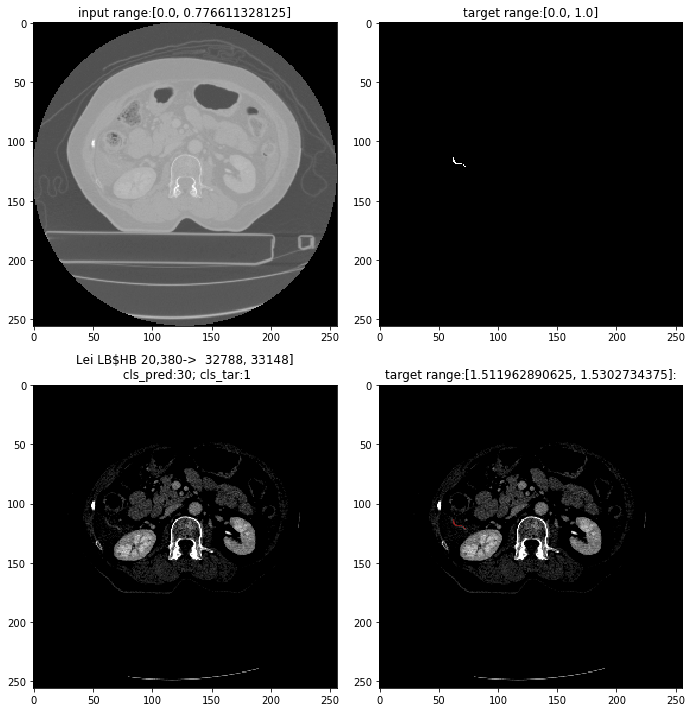

True
after reset basemodel trainable property: True


In [21]:
base_model =  en # use encoder as the base model

# check the loaded ae output
for image_features in test_dataset.take(2):
    dicom_path =  image_features[0]
    norm_input_w_image =  image_features[1]
    norm_input =  image_features[2]
    #     dicom_path = image_features[0].numpy()
    norm_target = image_features[3]
    cls_label = image_features[4]
    print("dicom_path:", dicom_path)
    print("input_image.shape", norm_input.shape)
    print("seg_label", norm_target.shape)
    print("cls_label", cls_label)

    
    # check the loaded encoder and decoder: model, norm_input, norm_input_w_image, norm_seg_target, cls_target, batch_idx, epoch, save=True, Train_or_not=True, Epoch_val =False
    new_generate_images(base_model, norm_input, norm_input_w_image, norm_target, cls_label,  1, 1, save=False, Train_or_not=False, Epoch_val =False)

# check the base base model traininable
print(base_model.trainable)

# 
trainable_or_not =  True

if trainable_or_not == True:
    base_model.trainable =  True # set encoder untranable
print("after reset basemodel trainable property:", base_model.trainable)

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 16)      160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      4640      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
flatten (Flatten)            (None, 131072)            0         
_________________________________________________________________
dense (Dense)                (None, 50)                6553

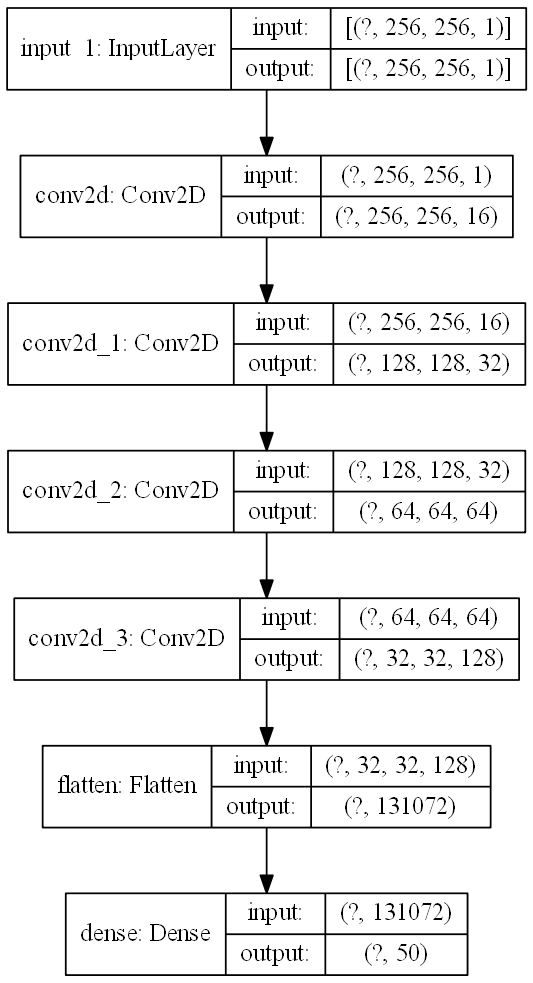

In [22]:
# check the trainable model architecture
base_model.summary()
tf.keras.utils.plot_model(base_model, to_file=base_model_path, show_shapes=True, dpi=128)

# of layers in the base_model: 7
Tensor("dense/Identity:0", shape=(None, 50), dtype=float32)
Tensor("dense/Identity:0", shape=(None, 50), dtype=float32)
Model: "classifier_head"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 16)      160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      4640      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
flatten (Flatten)            (

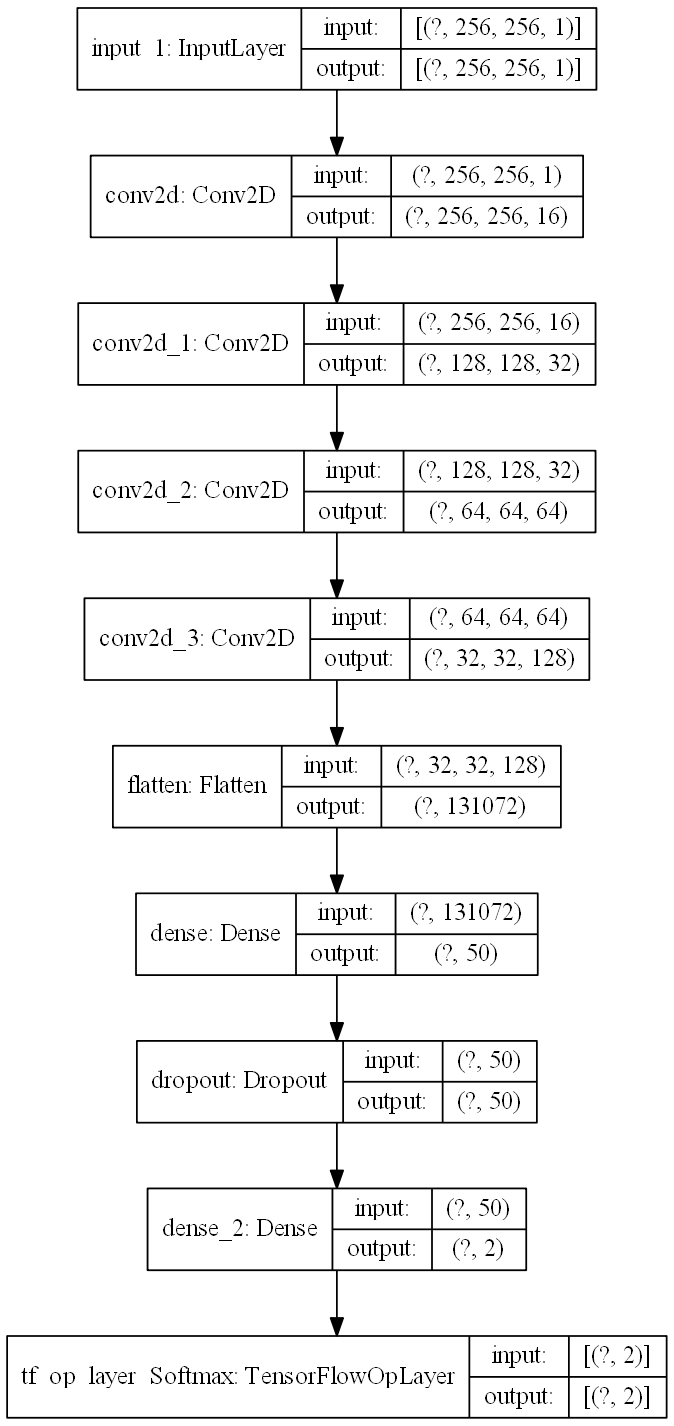

In [23]:
# add classification head for bleed exist or not
print("# of layers in the base_model:", len(base_model.layers))

class_dropout = tf.keras.layers.Dropout(0.5)(base_model.layers[-1].output)
class_head_nodes = tf.keras.layers.Dense(len(Class_names))(class_dropout)
class_softmax_output =  tf.nn.softmax(class_head_nodes)
print(base_model.output)
print(base_model.layers[-1].output)
Classifier =  tf.keras.Model(inputs=en_inputs, outputs=class_softmax_output, name='classifier_head')
# check the architecture
Classifier.summary()
tf.keras.utils.plot_model(Classifier, to_file=classifier_path, show_shapes=True, dpi=128)

In [24]:
# # set THE SETMENTATION PART
# # 1st take out the feature from the base_model
# base_feature =  base_model.layers[-3].output
# print(base_feature)


# define down_sample block as the pix-2-pix from tensorflow official set
# def downsample(filters, size, apply_batchnorm=True):
#     initializer = tf.random_normal_initializer(0., 0.02)

#     result = tf.keras.Sequential()
#     result.add(
#       tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
#                              kernel_initializer=initializer, use_bias=False))

#     if apply_batchnorm:
#         result.add(tf.keras.layers.BatchNormalization())

#     result.add(tf.keras.layers.LeakyReLU())

#     return result

# def upsample(filters, size, apply_dropout=False):
#     initializer = tf.random_normal_initializer(0., 0.02)

#     result = tf.keras.Sequential()
#     result.add(
#     tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
#                                     padding='same',
#                                     kernel_initializer=initializer,
#                                     use_bias=False))

#     result.add(tf.keras.layers.BatchNormalization())

#     if apply_dropout:
#         result.add(tf.keras.layers.Dropout(0.5))

#     result.add(tf.keras.layers.ReLU())

#     return result


# # def skips needed to be connected
# skips = []

# def en_for_seg():
# # new another path for the segmentation of the new model
#     x = downsample(64, 4, apply_batchnorm=False)(en_inputs) # output  (None, 128, 128, 64)
#     skips.append(x)
#     x = downsample(128, 4)(x)  # output (None, 64, 64, 128)
#     skips.append(x)
#     x = downsample(256, 4)(x)  # output (None, 32, 32, 256)
#     skips.append(x)
#     # if want seperate train the generator, return the Model object e.g. return tf.keras.Model(inputs=inputs, outputs=x)
#     return tf.keras.Model(inputs=en_inputs, outputs=x)

# en_coder_for_seg_out =  en_for_seg()
# print(en_coder_for_seg_out.output)
# tf.keras.utils.plot_model(en_coder_for_seg_out, to_file="encodre_for_seg.png", show_shapes=True, dpi=128)





# # concatenate the feature from base and feature from the new enocoder
# concate_features =  tf.keras.layers.Concatenate()([base_feature, en_coder_for_seg_out.output])
# print(concate_features)

# # start to one more step to encoder
# further_en = downsample(512, 4)(concate_features)  # output (None, 16, 16, 512)
# print("one more step encoding:",further_en)

# # global pooling for that one more step encoding fetures
# GA  = tf.keras.layers.GlobalAveragePooling2D()(further_en)  # squeeze
# print("GA:", GA)
# # RESHAPE GA  TO THE IMAGE FORMMAT
# RESHAPE_GA =  tf.reshape(GA, [-1,1,1, GA.shape[-1]])
# print("RESHAPE_GA:", RESHAPE_GA)
# #resize to the feature maps size
# resize_GA =  tf.image.resize(RESHAPE_GA, (further_en.shape[1], further_en.shape[2]))
# print("resized GA:", resize_GA)
# # concate future_en and reisze_GA
# bottom_concate =  tf.keras.layers.Concatenate()([resize_GA, further_en])
# print("bottom_concate:", bottom_concate)

# print()
# print("start to upsample--------->")
# # start to upsample and decoder from resize_GA and further_en
# up_feature1 =  upsample(512, 4) (bottom_concate) #  upsample/relarge ti [None, 32, 32, 1024] without dropout default false for drop
# print("up_feature1:", up_feature1)
# up_concate1 =  tf.keras.layers.Concatenate()([up_feature1, skips[-1]])
# print("up_concate1:", up_concate1)
# up_feature2 =  upsample(256, 4) (up_concate1) #  upsample/relarge ti [None, 64, 64, 256] without dropout default false for drop
# print("up_feature2:", up_feature2)
# up_concate2 =  tf.keras.layers.Concatenate()([up_feature2, skips[-2]])
# print("up_concate2:", up_concate2)
# up_feature3 =  upsample(128, 4) (up_concate2) #  upsample/relarge ti [None, 128, 128, 128] without dropout default false for drop
# print("up_feature3:", up_feature2)
# up_concate3 =  tf.keras.layers.Concatenate()([up_feature3, skips[-3]])
# print("up_concate3:", up_concate3)

# # last layer output
# initializer = tf.random_normal_initializer(0., 0.02)
# last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
#                                          strides=2, # stride 2
#                                          padding='same',
#                                          kernel_initializer=initializer,
#                                          activation='sigmoid') # (bs, 256, 256, 3)
# seg_out  =  last(up_concate3)

# Final_seg_model = tf.keras.Model(inputs=en_inputs, outputs=[seg_out, class_softmax_output])
# tf.keras.utils.plot_model(Final_seg_model, to_file=new_model_path, show_shapes=True, dpi=128)

dicom_path: tf.Tensor(
[b'E:\\dataset\\Leisang\\myTry\\BleedingDataDCM\\val/ZA-049_001/00000435.DCM'
 b'E:\\dataset\\Leisang\\myTry\\BleedingDataDCM\\val/ZA-049_001/00000436.DCM'], shape=(2,), dtype=string)
input_image.shape (2, 256, 256, 1)
seg_label (2, 256, 256, 1)
cls_label tf.Tensor([1 1], shape=(2,), dtype=int64)
input range [0.0, 0.8173828125]:
output1 shape: (2,)


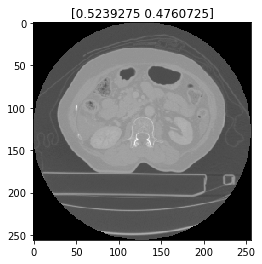

dicom_path: tf.Tensor(
[b'E:\\dataset\\Leisang\\myTry\\BleedingDataDCM\\val/ZA-049_001/00000437.DCM'
 b'E:\\dataset\\Leisang\\myTry\\BleedingDataDCM\\val/ZA-049_001/00000438.DCM'], shape=(2,), dtype=string)
input_image.shape (2, 256, 256, 1)
seg_label (2, 256, 256, 1)
cls_label tf.Tensor([1 1], shape=(2,), dtype=int64)
input range [0.0, 0.77734375]:
output1 shape: (2,)


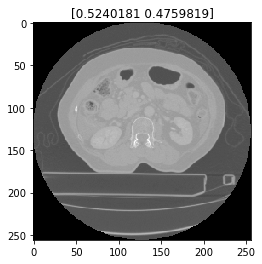

In [25]:
# check new model
# check the AE OUTPUT
# print("inp.shape:", cliped_norm_input.shape)
# print("inp[tf.newaxis,...]:", cliped_norm_input[tf.newaxis,...].shape)
# AE_output = autoencoder(resized_input[tf.newaxis,...], training=False)  # inp is the image sample from cell code 6 ; 
# print(AE_output.shape)
# plt.imshow(np.squeeze(AE_output[0,...]), cmap="gray")

# check the loaded ae output
for image_features in test_dataset.take(2):
    dicom_path =  image_features[0]
    norm_input_w_image =  image_features[1]
    norm_input =  image_features[2]
    #     dicom_path = image_features[0].numpy()
    norm_target = image_features[3]
    cls_label = image_features[4]
    print("dicom_path:", dicom_path)
    print("input_image.shape", norm_input.shape)
    print("seg_label", norm_target.shape)
    print("cls_label", cls_label)
 
    
    # check the range of input test dataset
    print("input range [{}, {}]:".format(norm_input.numpy().min(), norm_input.numpy().max()))
    
    new_model_output =  Classifier(norm_input)
    # outputs=[seg_out, class_sigmoid_output]
    output=   new_model_output[0]

    print("output1 shape:", output.shape)  

#     test_total_loss, test_BCE_loss, test_Huber_loss = test_step(AE, TEST_input, TEST_target, epoch) 
#     generate_images(AE, TEST_input, TEST_target,TEST_dicom_path,test_total_loss.numpy(), int(step), int(epoch), save=False)
    plt.imshow(np.squeeze(norm_input[0]), cmap="gray")
    plt.title(str(output.numpy()))
    plt.show()
#     # check the loaded encoder and decoder
#     en_de_generate_images(en, de,TEST_input, TEST_target,TEST_dicom_path, int(step), int(epoch), save=False)

In [26]:
# design new loss for the new model as new_train_step, new_test_step
new_optimizer =  tf.keras.optimizers.Adam(1e-4)
# from tf.keras.utils import to_categorical
BCE =  tf.keras.losses.BinaryCrossentropy() 
Huber =  tf.keras.losses.Huber(delta=0.1)
SCC = tf.keras.losses.SparseCategoricalCrossentropy()
@tf.function()
# define losses
def new_compute_loss(pred_cls, gt_cls):
    
#     #seg  cross_entropy,  use reduce mean not sum, otherwise loss will be very big
#     seg_BCE_loss = BCE(y_true=gt_seg, y_pred=pred_seg) 
    
    
#     # L1 loss 
# #     L1_loss = tf.reduce_mean(tf.abs(x - decoded_x))
    
#     #seg Huber_loss
#     seg_Huber_loss = Huber(y_true=gt_seg, y_pred=pred_seg)
    
#     seg_total_loss = seg_Huber_loss + seg_BCE_loss
    
    
    # use tf.keras.losses.SparseCategoricalCrossentropy instead of BCE , no need one-hot tranfermat
    cls_SCC_loss=  SCC(y_true=gt_cls, y_pred=pred_cls)
    
    # total_loss = cls_BCE_loss + seg_loss
    total_loss = cls_SCC_loss 
    return total_loss, cls_SCC_loss
    

# def mask_to_categorical(cls_tar, num_cls=2):
#     tar = tf.one_hot(tf.cast(cls_tar, tf.int32), num_cls)
#     tar = tf.cast(tar, tf.float32)
#     return tar

# @tf.function()
def new_train_step(model, input, cls_target, training):
    # change cls labe 0 or 1 into  [1, 0] [0, 1]
#     print(cls_target)
#     cls_target = mask_to_categorical(cls_target)
#     print("in trianing step")
    with tf.GradientTape() as tape:  # very interesting
        # outputs=[seg_out, class_sigmoid_output] 
        class_softmax_output= model(input, training=training)
        total_loss, cls_SCC_loss = new_compute_loss(pred_cls=class_softmax_output, 
                                                            gt_cls=cls_target)
    gradients = tape.gradient(total_loss, model.trainable_variables)
    new_optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return total_loss, cls_SCC_loss

# @tf.function()
def new_test_step(model2, input2, cls_target2, training2):
    with tf.GradientTape() as tape:  # very interesting
        class_softmax_output2= model2(input2, training=training2)
        total_loss2, cls_SCC_loss2 = new_compute_loss(
                                                            pred_cls=class_softmax_output2, 
                                                            gt_cls=cls_target2)
    return total_loss2, cls_SCC_loss2

## Confusion matrix define


In [27]:
!pip install scikit-learn
!pip install pandas
import sklearn.metrics
import itertools
# import seaborn as sns
import pandas as pd
def plot_confusion_matrix(cm, class_names, num_s, final_step, epoch, save=True):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.

    Args:
    cm (array, shape = [n, n]): a confusion matrix of integer classes
    class_names (array, shape = [n]): String names of the integer classes e.g, ["dog", "cat"]
    """
    figure = plt.figure(figsize=(12, 12))
#     plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix(range[{}, {}] \n # of samples: {} toatal train steps:{})".format(cm.min(), cm.max(), num_s, final_step))
    
     # Normalize the confusion matrix.
    norm_cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
    plt.imshow(norm_cm, interpolation='nearest', cmap=plt.cm.Blues)
     # Use white text if squares are dark; otherwise black.
    threshold = norm_cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if norm_cm[i, j] > threshold else "black"
        plt.text(j, i, "{}({})".format(cm[i, j],norm_cm[i, j]), horizontalalignment="center", color=color)
    plt.colorbar()  # rember the jupyter lab will remember the plt color operation so the coloar may related to the normalized value if not clean 
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names, rotation=45)

#     # Normalize the confusion matrix.
#     cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

#     # Use white text if squares are dark; otherwise black.
#     threshold = cm.max() / 2.
#     for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#         color = "white" if cm[i, j] > threshold else "black"
#         plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)

    plt.tight_layout()
    plt.ylabel('True label', labelpad=0)
    plt.xlabel('Predicted label')
    if save:    
        plt.savefig(test_confusion_matrix + "/Test_cm_at_epoch_{:04d}.png".format(epoch))
    else:
        pass
    return figure



# # define calculate cm
# def log_confusion_matrix_all(model,test_inputs, cls_tar, epoch, save):
#     # Use the model to predict the values from the validation dataset.
#     class_softmax_output = model.predict(test_inputs)
#     test_pred = np.argmax(class_softmax_output, axis=1)
    
    
#     # Calculate the confusion matrix.
#     cm = sklearn.metrics.confusion_matrix(cls_tar, test_pred)


# plot diagonal of confusion matrix with respect to epoch
def log_plot_confusion_matrix_at_epochs(cm_concate_axis0, class_names, epoch, at_epoch, save=True):
    if epoch % at_epoch ==0:
        figure = plt.figure(figsize=(8, 8))
    #     plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title("Confusion matrix(range[{}, {}]) at epoch {}(total {} epochs)".format(cm_concate_axis0.min(), cm_concate_axis0.max(), at_epoch, cm_concate_axis0.shape[0]))

        print("concate cm shape:",cm_concate_axis0.shape)
        # plot cm_diag vs epoch
    #     plt.plot(range(cm_concate_axis0.shape[0]), )
        for i in range(cm_concate_axis0.shape[1]):
            plt.plot(range(1, cm_concate_axis0.shape[0]+1), cm_concate_axis0[:,i], "o--", label = '{}'.format(class_names[i]))

        plt.legend(loc='best')
        plt.tight_layout()
        plt.ylabel('True diagonal probabilies', labelpad=0)
        plt.xlabel('Epochs')
        if save:    
            plt.savefig(test_cm_diags + "/Test_cm_diag_at_epoch_{:04d}.png".format(epoch))
        else:
            pass

    
def plot_batch_test_loss(test_batch_loss_catches, epoch):
    figure = plt.figure(figsize=(8, 8))
#     #     plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
#     plt.title("test loss(range[{%.2f}, {%.2f}]) at epoch {} /n total batches:{}".format(test_batch_loss_catches.min(), test_batch_loss_catches.max(), epoch, test_batch_loss_catches.shape[1]))
#     epoch_x =  range(1, epoch+1)
#     data = {"epochs": } 
    
    data={}
#     sns.sns.boxplot(data = test_batch_loss_catches
#             ,x = 'score'
#             )
    # plot cm_diag vs epoch
    #     plt.plot(range(cm_concate_axis0.shape[0]), )

    # build dictory data for sns box plot
    for i in range(test_batch_loss_catches.shape[0]):
        data[str(i+1)] = test_batch_loss_catches[i, :]
#         x_axis =  []
#         x_axis += test_batch_loss_catches.shape[1] *[epoch]
#         print("x_axis:", x_axis)
#         plt.plot(x_axis, test_batch_loss_catches[i], "o--", label = '{}'.format(epoch))
#         plt.plot(x_axis[0], np.mean(test_batch_loss_catches), label = 'mean {%.2f} at epoch {}'.format(np.mean(test_batch_loss_catches), epoch))
#     plt.legend(loc='best')
#     plt.tight_layout()
#     plt.ylabel('Test batch loss', labelpad=0)
#     plt.xlabel('Epochs', labelpad=0)
       
#     plt.savefig(test_batch_losses + "/Test_loss_at_epoch_{:04d}.png".format(epoch))
    print("test loss data:", data)
    df = pd.DataFrame(data)
    df.plot.box(title="test batch losses per epoch")
    plt.savefig(test_batch_losses + "/Test_loss_at_epoch_{:04d}.png".format(epoch))
    
# define confusion matrix for classification displaying
def log_confusion_matrix_all(model,test_inputs, class_names,cls_tar, epoch, save):
    # Use the model to predict the values from the validation dataset.
    class_softmax_output = model.predict(test_inputs)
    test_pred = np.argmax(class_softmax_output, axis=1)
    
    
    # Calculate the confusion matrix.
    cm = sklearn.metrics.confusion_matrix(cls_tar, test_pred)
    # Log the confusion matrix as an image summary.

    figure = plot_confusion_matrix(cm, class_names, epoch, batch_indx, save)
    
    return cm
#     cm_image = plot_to_image(figure)


# def return_cls_preds_tars(single_cls_pred, single_cls_tars):
#     print("single_cls_pred:", single_cls_pred)
#     print("single_cls_tars:", single_cls_tars)

# define confusion matrix for classification displaying
def log_confusion_matrix_without_model(cls_preds, class_names,cls_tars, final_step, epoch, save):
    # Use the model to predict the values from the validation dataset.
#     seg_out, class_softmax_output = model.predict(test_inputs)
    
    # check the number of samples
    num_s =  cls_preds.shape[0]
    
    cls_preds_ints = np.argmax(cls_preds, axis=1)
#     print("cls_preds_ints:", cls_preds_ints, cls_preds_ints.shape)
#     print("cls_tars:", cls_tars, cls_tars.shape)
    
    # Calculate the confusion matrix.
#     cm = sklearn.metrics.confusion_matrix(cls_tars, cls_preds_ints,  labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
    cm = sklearn.metrics.confusion_matrix(cls_tars, cls_preds_ints,  labels=[0, 1])  # for binary classification
    print("cm:", cm)
    # Log the confusion matrix as an image summary.

    figure = plot_confusion_matrix(cm, class_names, num_s,final_step, epoch, save)
    
    # calcualte norm cm for the later diagnal plots
    norm_cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
    
    return norm_cm
#     cm_image = plot_to_image(figure)

In [28]:
def write_losses_tb(writer, avg_losses, epoch):
    """
     avg_losses = [total_loss, seg_loss, cls_loss]
    """
    with writer.as_default():
        print("writing train logs to tensorboard...")                                                       
        # write scalars to the tensorboard after each train step
        tf.summary.scalar('total_loss', avg_losses[0].result(), step=epoch)
#         tf.summary.scalar('seg_total_loss', avg_losses[1].result(), step=epoch)
        tf.summary.scalar('cls_SCE_loss', avg_losses[1].result(), step=epoch)


def train_display_save_at(model, Tr_norm_input, Tr_norm_input_w_image, Tr_norm_seg_label,Tr_cls_label,   step, epoch, freq_step =100, save=True, Train_or_not=True):
    if step % freq_step == 0:
        print("train image checking----------------------------------------------------------------------------------->")
#         new_generate_images(model, Tr_norm_input, Tr_norm_input_w_image, Tr_norm_target, Tr_cls_label, Tr_dicom_path,  step, epoch, save=save, Train_or_not=Train_or_not)
        new_generate_images(model, Tr_norm_input,Tr_norm_input_w_image, Tr_norm_seg_label,Tr_cls_label,  step, epoch, save=save, Train_or_not=Train_or_not)
#         print('Epoch{}: {}/{}: total_loss: {}; cls_SCE_loss: {}; seg_total_loss: {} '.format(epoch, step, resampled_steps_per_epoch, total_loss, cls_SCE_loss, seg_total_loss))
        
def test_display_save_at(val_dataset, model, step, epoch, freq_step= 100, save=True, Train_or_not=False):
    # every 100 batch step show the generate test image to check.
    if int(step) % freq_step == 0:
        display.clear_output(wait=True)
           
        # take the 1st batch from the validation dataset
        for image_featuresx in val_dataset.take(1):

#         print("test input:", image_features3)
        # feature extraction
#             TE_dicom_path3 =  image_features3[0]
            Tex_input_w_image =  image_featuresx[1]
            tex_input =  image_featuresx[2]
            Tex_seg_label = image_featuresx[3]
            tex_target = image_featuresx[4]
#         for tex_input, tex_target in test_dataset.take(1):
 
            #         plt.figure()
            #         plt.imshow(np.squeeze(tex_input[0]))
            #         plt.colorbar()
            #         plt.grid(False)
            #         plt.title(str(tex_target[0].numpy()))
            #         plt.show()
#           
            print("The 1st batch test image checking----------------------------------------------------------------------------------->")
            new_generate_images(model, tex_input,Tex_input_w_image, Tex_seg_label, tex_target,step, epoch, save=save, Train_or_not=Train_or_not)
            # every 400 steps save the genrate images



def test_at_each_epoch(val_dataset, model, step, epoch, temp_loss,save=True, training=False):
    # initialize 
    epoch_val_flag = True
    # initialize for evaluating average metric
    test_total_loss_mean = tf.keras.metrics.Mean()
    test_seg_total_loss_mean = tf.keras.metrics.Mean()
    test_cls_SCC_loss_mean = tf.keras.metrics.Mean()

    # 
    cls_preds_entire = None
    cls_tar_entire = None
    
    #
    test_loss_catches = []
#     print(loss_catches.shape)

    idx = 0
    # start to go through entire validation dataset
#     for  image_features3 in val_dataset.take(10):     # just for debug   $$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
#     for tex_input, tex_target in test_dataset.take(1):                                      
    for  idx, image_features3 in enumerate(val_dataset):
#         if idx > 1000:   # just for debug   $$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
#             break         # just for debug   $$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
        print("test batch:", idx)
#         print("test input:", image_features3)
        # feature extraction
        TE_dicom_path3 =  image_features3[0]
        TE_norm_input_w_image3 =  image_features3[1]
        TE_norm_input3 =  image_features3[2]
        TE_norm_target3 = image_features3[3]
        TE_cls_label3 = image_features3[4]
#         tex_input = image_features3[0]
#         tex_target = image_features3[1]
        # one loss evluation : new_test_step(model, input, seg_target, cls_target, epoch)   ///new_train_step(model, input, cls_target, training)
        test_total_loss, test_cls_SCC_loss  = new_test_step(model, TE_norm_input3, TE_cls_label3, training2=training)
        test_total_loss_mean(test_total_loss)
#         test_seg_total_loss_mean(test_seg_total_loss)
        test_cls_SCC_loss_mean(test_cls_SCC_loss)
        
        test_loss_catches.append(test_cls_SCC_loss)
        
#         if idx % loss_catches.shape[1]==0:
            # plot curve of eapoch loss
        
     
        
        # save epoch validation image in the folder every 10 batches save
        
#         if idx >10:  # just for debug   $$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
#             break    # just for debug   $$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
        
        if idx > n_positive_test_batches:  # when  evaluating negative val dataset using larger spacing
            
            if idx % 500 ==0:
                  new_generate_images(model, TE_norm_input3, TE_norm_input_w_image3,TE_norm_target3, TE_cls_label3 ,idx,  #model, norm_input, norm_input_w_image, norm_seg_target, cls_target, batch_idx, epoch, save=True, Train_or_not=True, Epoch_val =False
                                    epoch, save=save, Train_or_not=training, Epoch_val=epoch_val_flag) 
           
        else:
            new_generate_images(model, TE_norm_input3,  TE_norm_input_w_image3,TE_norm_target3, TE_cls_label3 ,idx, 
                                    epoch, save=save, Train_or_not=training, Epoch_val=epoch_val_flag)                                               
        display.clear_output(wait=True)

         # Test input--------------batch input and targets to evaluate confusion matrix====================》
        cls_preds =model.predict(TE_norm_input3) # predicts has shape [batch size, len(classes)]
        print("single batch targets shape:", cls_preds.shape)
        print("single batch preds shape:", cls_preds.shape)
        if cls_preds_entire is None:
            cls_preds_entire = cls_preds
            cls_tar_entire = TE_cls_label3.numpy()
#                   
        else: 
            cls_preds_entire =  np.concatenate((cls_preds_entire, cls_preds), axis=0)
            cls_tar_entire = np.concatenate((cls_tar_entire, TE_cls_label3.numpy()), axis=0)
            
#         idx +=1       # just for debug   $$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
            
    print("preds_entire.shape", cls_preds_entire, cls_preds_entire.shape)
    print("cls_entire.shape", cls_tar_entire, cls_preds_entire.shape)   # https://www.tensorflow.org/tensorboard/image_summaries
#                 return_cls_preds_tars(single_cls_pred, single_cls_tars)
#             # check initial confusion matrix
    
    # log the norm
    norm_cm = log_confusion_matrix_without_model(cls_preds=cls_preds_entire, class_names=Class_names, cls_tars=cls_tar_entire,final_step =step, epoch=epoch, save=save)
    #

    print('Epoch: {}, Test total_loss set loss: {},  cls_loss: {}'.format(epoch,
                                                test_total_loss_mean.result(), test_cls_SCC_loss_mean.result()))

    epoch_val_flag = False # one epoch finish so set flag back
    
    
    # write logs to tensorboard:    avg_losses = [total_loss, seg_loss, cls_loss]
    # write test losses to the tensorboard
    print("writing test logs to tensorboard...") 
    write_losses_tb(val_summary_writer, [test_total_loss_mean, test_cls_SCC_loss_mean], epoch)

  
    # check whether needs to save the model
    if test_total_loss_mean.result() < temp_loss:
        save_path =  new_manager.save() # save the checkpoint and return the save path
        print("Saved checkpoint for epoch {}-  step {}: {}".format(epoch, step, save_path))
        test_avg_tmp_loss =  test_total_loss_mean.result()
    
    return norm_cm,   np.array(test_loss_catches).reshape((1,-1))

In [29]:
take_new_train_batches =  3035
def train_process(train_dataset, val_dataset, step, start_epoch, total_epochs):
    # some initial parameters
    # test average_loss = for saving the test results
    test_avg_tmp_loss = 100
    norm_cm_diags = None   

    test_loss_epochs = None
    for epoch in range(int(start_epoch), total_epochs+1):
        # initializations at each epoch
        
        train_total_loss_mean = tf.keras.metrics.Mean()
#         train_seg_total_loss_mean = tf.keras.metrics.Mean()
        train_cls_SCC_loss_mean = tf.keras.metrics.Mean()
     
        
        for image_features0 in train_dataset:
            # train sample extraction
            TR_dicom_path =  image_features0[0]
            TR_norm_input_w_image =  image_features0[1]
            TR_norm_input =  image_features0[2]
            TR_norm_target = image_features0[3]
            TR_cls_label = image_features0[4]

            # one train step loss calculation and optimization
            total_loss, cls_SCC_loss = new_train_step(Classifier, TR_norm_input, TR_cls_label, training=True)
            train_total_loss_mean(total_loss)
#             train_seg_total_loss_mean(seg_total_loss)
            train_cls_SCC_loss_mean(cls_SCC_loss)
            

            # display and save training image with results
            train_display_save_at(Classifier, TR_norm_input,TR_norm_input_w_image,TR_norm_target, TR_cls_label,  int(step), epoch, freq_step=500, save=True, Train_or_not=True )

            
            # test check at some step
            test_display_save_at(val_dataset, Classifier, int(step), epoch, freq_step= 500, save=True, Train_or_not=False)
                
            
#             # if step > positive number of samples, training epoch finished else, continous for the current epoch training and add the step with 1
            if step > 1000:                                 # just for debug   $$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
                print("one epoch finihsed")              # just for debug   $$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$        
#                 step.assign_add(1)                       # just for debug   $$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
                break
#     #         if step > resampled_steps_per_epoch:
                
#     #             break
#             else:
            print("one BATCH finihsed")
            if step % 20 ==0:
                display.clear_output(wait=True)
            print("step:", int(step))
            
#             if step > 30:                              # just for debug   $$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
#             if step > num_train_samples:
#                 break
            
            step.assign_add(1)
            
        
        
        
            
        # finihsed epoch and start epoch validaion : save images for the entire validation dataset(including all positives, but some negatives), tensorboard log writing, whether to save the model
        each_epoch_norm_cm, test_loss_catches_per_epoch = test_at_each_epoch(val_dataset, Classifier, int(step)-1, epoch, temp_loss=test_avg_tmp_loss, save=True, training = False)
        print("test_loss_catches_per_epoch.shape:", test_loss_catches_per_epoch.shape)
        norm_cm_diag_each_epoch = np.reshape(np.diag(each_epoch_norm_cm),(1, -1))
        if norm_cm_diags is None:
            norm_cm_diags =  norm_cm_diag_each_epoch
        else:
            norm_cm_diags=  np.concatenate((norm_cm_diags,norm_cm_diag_each_epoch ), axis = 0)
            
        log_plot_confusion_matrix_at_epochs(norm_cm_diags, Class_names, epoch, at_epoch=7, save=True)
        
        if test_loss_epochs is  None:
            test_loss_epochs = test_loss_catches_per_epoch
        else:
            test_loss_epochs=  np.concatenate((test_loss_epochs,test_loss_catches_per_epoch ), axis = 0)
        # plot tepoch test losses
        plot_batch_test_loss(test_loss_epochs, epoch)
        
        # write train epoch average loss to the tensorboard
        print("writing train logs to tensorboard...") 
        write_losses_tb(train_summary_writer, [train_total_loss_mean, train_cls_SCC_loss_mean], epoch)
            
      
        # when epoch fisnihed add epoch counter and reset the batch step 
        start_epoch.assign_add(1)     
        step.assign(1)
        
        
    # when training finihsed
    print("training finished") 


step: 460
one BATCH finihsed
step: 461
one BATCH finihsed
step: 462
one BATCH finihsed
step: 463
one BATCH finihsed
step: 464
one BATCH finihsed
step: 465
one BATCH finihsed
step: 466
one BATCH finihsed
step: 467
one BATCH finihsed
step: 468
one BATCH finihsed
step: 469
one BATCH finihsed
step: 470
one BATCH finihsed
step: 471
one BATCH finihsed
step: 472
one BATCH finihsed
step: 473
one BATCH finihsed
step: 474


KeyboardInterrupt: 

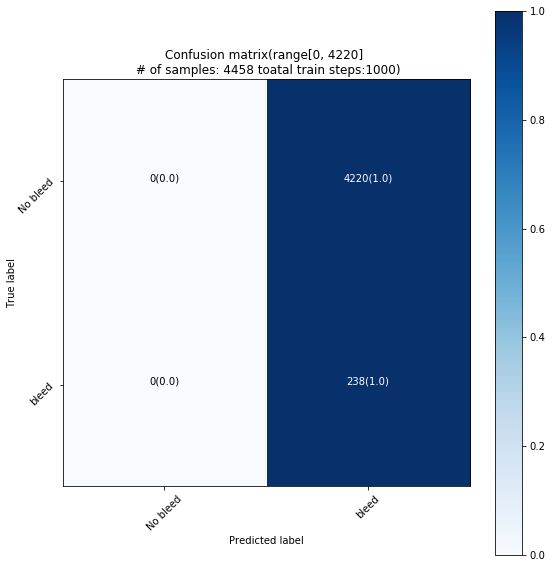

<Figure size 576x576 with 0 Axes>

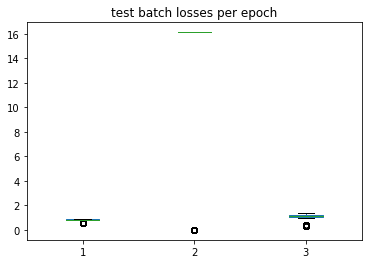

In [30]:
import time


# build_new check point manager
new_ckpt_prefix = os.path.join(checkpoint_dir, "ckpt")
if not os.path.exists(new_ckpt_prefix):
    os.makedirs(new_ckpt_prefix)
#  contents of states to be saved as attributes on the checkpoint object
new_ckpt_ob = tf.train.Checkpoint(step= tf.Variable(1),
                                    epoch=  tf.Variable(1),
                                    optimizer=new_optimizer,
                                     new_model =  Classifier
                                 )
# define checkpoint manager
new_manager =  tf.train.CheckpointManager(new_ckpt_ob, new_ckpt_prefix, max_to_keep=1)

# check the whether there is a checkpoint in the checkpoint folder, if it is restore from it
if new_manager.latest_checkpoint:
    print("Restored from {}".format(new_manager.latest_checkpoint))
    new_ckpt_ob.restore(new_manager.latest_checkpoint)
else:
    print("Initializing from scratch.")

# reset checkcpoint.step for each epoch
step =  new_ckpt_ob.step
ckpt_epoch =  new_ckpt_ob.epoch  


epochs =  200
# start train_process
train_process(train_dataset, test_dataset, step, ckpt_epoch, total_epochs=epochs)
